####Analytics Vidya</b>
###Face detection and counting</p></b>
<p>People detection and head counting is one of the classical albeit challenging computer vision application. For this problem, given a group selfie/photo, you are required to count the number of heads present in the picture. You are provided with a training set of images with coordinates of bounding box and head count for each image and need to predict the headcount for each image in the test set.</p></br>

In [ ]:
from google.colab import drive
import zipfile as zip1
import os
drive.mount('/content/drive')
zip_ref = zip1.ZipFile('./drive/My Drive/Colab Notebooks/AnalyticsVidya/train_HNzkrPW (1).zip', 'r')
zip_ref.extractall('train/')
zip_ref.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

IMG_SIZE = 128
BATCH_SIZE = 128
traindatagen = ImageDataGenerator(rescale=1./255)
traincsv = pd.read_csv('train/train.csv',dtype={'Name': str,'HeadCount':int})
trainFaceMaskcsv = pd.read_csv('train/bbox_train.csv',dtype={'Name': str,'width':float,'height':float,'xmin':float,'ymin':float,'xmax':float,'ymax':float})
trainFaceMaskcsv['xmin'] = trainFaceMaskcsv['xmin']*IMG_SIZE/trainFaceMaskcsv['width']
trainFaceMaskcsv['xmax'] = trainFaceMaskcsv['xmax']*IMG_SIZE/trainFaceMaskcsv['width']
trainFaceMaskcsv['ymin'] = trainFaceMaskcsv['ymin']*IMG_SIZE/trainFaceMaskcsv['height']
trainFaceMaskcsv['ymax'] = trainFaceMaskcsv['ymax']*IMG_SIZE/trainFaceMaskcsv['height']

traingenerator = traindatagen.flow_from_dataframe(traincsv, directory='train/image_data/',x_col='Name', y_col=['Name','HeadCount'],target_size=(IMG_SIZE,IMG_SIZE), color_mode='rgb',class_mode='raw', batch_size=BATCH_SIZE,shuffle=False, seed=10)

Found 5733 validated image filenames.


In [ ]:
import numpy as np
def get_iou(a, epsilon=1e-5):
    a[:,9] = np.maximum(a[:,1], a[:,5])
    a[:,10] = np.maximum(a[:,2], a[:,6])
    a[:,11] = np.minimum(a[:,3], a[:,7])
    a[:,12] = np.minimum(a[:,4], a[:,8])
    overlap = np.multiply(np.maximum(0,np.subtract(a[:,11],a[:,9])),np.maximum(0,np.subtract(a[:,12],a[:,10])))
    area_a = np.multiply(np.subtract(a[:,3],a[:,1]),np.subtract(a[:,4],a[:,2]))
    area_b = np.multiply(np.subtract(a[:,7],a[:,5]),np.subtract(a[:,8],a[:,6]))
    area_combined = np.subtract(area_a+area_b,overlap)+epsilon
    a[:,13] = np.divide(overlap,area_combined)*IMG_SIZE
    a[np.where(a[:,13] > 0),14] = IMG_SIZE 
    a[np.where(a[:,13] <= 0),14] = 0
    return a

In [ ]:
def get_iou_tf(a, epsilon=1e-5):
  a1max = tf.maximum(a[:,0], a[:,4])
  a2max = tf.maximum(a[:,1], a[:,5])
  a3min = tf.minimum(a[:,2], a[:,6])
  a4min = tf.minimum(a[:,3], a[:,7])
  overlap = tf.multiply(tf.maximum(0.0,tf.subtract(a3min,a1max)),tf.maximum(0.0,tf.subtract(a4min,a2max)))
  area_a = tf.multiply(tf.subtract(a[:,2],a[:,0]),tf.subtract(a[:,3],a[:,1]))
  area_b = tf.multiply(tf.subtract(a[:,6],a[:,4]),tf.subtract(a[:,7],a[:,5]))
  area_combined = tf.add(tf.subtract(tf.add(area_a,area_b),overlap),epsilon)
  return tf.divide(overlap,area_combined)

In [ ]:
def getAnchorBasedSlidingWindow(image_size,anchor):
  array = []
  for i in range(0,image_size,anchor):
    for j in range(0,image_size,anchor):
      array.append([i,j,i+anchor,j+anchor])
  return array

def getallSlidingwindows(image_size):
  window8 = np.array(getAnchorBasedSlidingWindow(image_size,8))
  window16 = np.array(getAnchorBasedSlidingWindow(image_size,16))
  window32 = np.array(getAnchorBasedSlidingWindow(image_size,32))
  window64 = np.array(getAnchorBasedSlidingWindow(image_size,64))

  return np.vstack([np.hstack([np.ones(shape=(window8.shape[0],1))*8,window8]),
            np.hstack([np.ones(shape=(window16.shape[0],1))*16,window16]),
            np.hstack([np.ones(shape=(window32.shape[0],1))*32,window32]),
            np.hstack([np.ones(shape=(window64.shape[0],1))*64,window64])])

In [ ]:
def get_faceMasks(traingenerator):
  while True:
    batch_x, batch_y = next(traingenerator)
    allwin = getallSlidingwindows(IMG_SIZE)
    facemasks8 = np.zeros(shape=(batch_y.shape[0],int(IMG_SIZE/8),int(IMG_SIZE/8),7))
    facemasks16 = np.zeros(shape=(batch_y.shape[0],int(IMG_SIZE/16),int(IMG_SIZE/16),7))
    facemasks32 = np.zeros(shape=(batch_y.shape[0],int(IMG_SIZE/32),int(IMG_SIZE/32),7))
    facemasks64 = np.zeros(shape=(batch_y.shape[0],int(IMG_SIZE/64),int(IMG_SIZE/64),7))
    onestemp = np.ones(shape=(allwin.shape[0]),dtype=np.float64)
    for i in range(batch_y.shape[0]):
      faceList = trainFaceMaskcsv.where(trainFaceMaskcsv['Name']==batch_y[i][0])
      faceList = faceList[faceList.Name.notnull()]
      arr = []
      for face in range(faceList['Name'].count()):
        arr.append(np.concatenate([allwin,np.stack([onestemp*faceList['xmin'].iloc[face],onestemp*faceList['ymin'].iloc[face],onestemp*faceList['xmax'].iloc[face],onestemp*faceList['ymax'].iloc[face],
                                    onestemp*0,onestemp*0,onestemp*0,onestemp*0,onestemp*0,onestemp*0,onestemp*faceList['Name'].count()],axis=1)],axis=1))
      ious = get_iou(np.array(arr).reshape(faceList['Name'].count()*allwin.shape[0],16))
      ious2 = pd.DataFrame(ious)
      idx = ious2.loc[ious2.reset_index().groupby([0,1,2,3,4])[13].idxmax()]
      idxarray = np.array(idx)
      facemasks8[i] = np.reshape((idxarray[idxarray[:,0]==8][:,1:16]/IMG_SIZE)[:,[8,9,10,11,12,13,14]],newshape=(int(IMG_SIZE/8),int(IMG_SIZE/8),7))
      facemasks16[i] = np.reshape((idxarray[idxarray[:,0]==16][:,1:16]/IMG_SIZE)[:,[8,9,10,11,12,13,14]],newshape=(int(IMG_SIZE/16),int(IMG_SIZE/16),7))
      facemasks32[i] = np.reshape((idxarray[idxarray[:,0]==32][:,1:16]/IMG_SIZE)[:,[8,9,10,11,12,13,14]],newshape=(int(IMG_SIZE/32),int(IMG_SIZE/32),7))
      facemasks64[i] = np.reshape((idxarray[idxarray[:,0]==64][:,1:16]/IMG_SIZE)[:,[8,9,10,11,12,13,14]],newshape=(int(IMG_SIZE/64),int(IMG_SIZE/64),7))
    yield batch_x, [andfacemasks8.astype('float32'),facemasks16.astype('float32'),facemasks32.astype('float32'),facemasks64.astype('float32')]

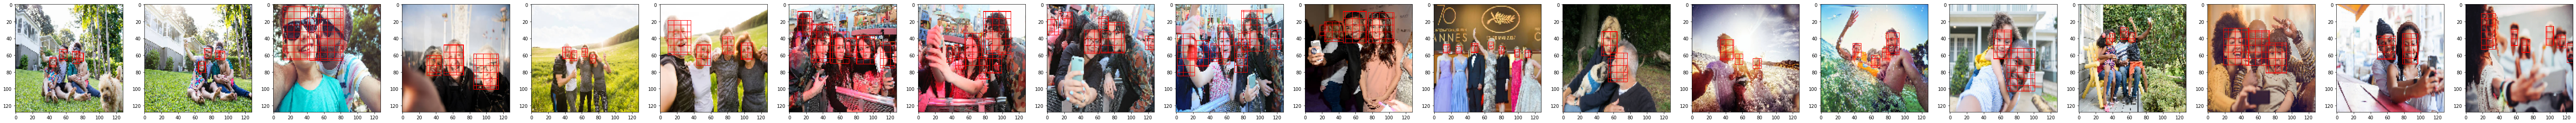

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
x_train,[m1,m2,m3,m4] = next(get_faceMasks(traingenerator))
newm1 = np.reshape(m1,newshape=(m1.shape[0],int((IMG_SIZE*IMG_SIZE)/(8*8)),7))
newm2 = np.reshape(m2,newshape=(m2.shape[0],int((IMG_SIZE*IMG_SIZE)/(16*16)),7))
newm3 = np.reshape(m3,newshape=(m3.shape[0],int((IMG_SIZE*IMG_SIZE)/(32*32)),7))
newm4 = np.reshape(m4,newshape=(m4.shape[0],int((IMG_SIZE*IMG_SIZE)/(64*64)),7))
allanchors = np.hstack([newm1,newm2,newm3,newm4])
fig,ax = plt.subplots(1,20,figsize=(100,5))
for pi in range(20):
  img_to_show = x_train[pi]
  ax[pi].imshow(img_to_show)
  boxes = allanchors[pi][allanchors[pi][:,5]==1]*IMG_SIZE
  for box in range(len(boxes)):
    ax[pi].add_patch(patches.Rectangle((boxes[box,0],boxes[box,1]),boxes[box,2]-boxes[box,0],boxes[box,3]-boxes[box,1],linewidth=1,edgecolor='r',facecolor='none'))
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.python.keras.layers import (Flatten,LeakyReLU,AveragePooling2D,concatenate,
                                            Reshape,Activation,Input, Conv2D, MaxPooling2D,
                                            BatchNormalization, GlobalAveragePooling2D,SpatialDropout2D)
def resNetBlock(input_image,num):

  layer1 = Conv2D(128, 3, strides=(1,1), padding='same', use_bias=False,name ='rone'+str(num))(input_image)
  layer1 = BatchNormalization()(layer1)
  layer1 = LeakyReLU(alpha=0.1)(layer1)
  
  layer3 = Conv2D(64, 1, strides=(1,1), padding='same', use_bias=False,name='rtwo'+str(num))(layer1)
  layer3 = BatchNormalization()(layer3)
  layer3 = LeakyReLU(alpha=0.1)(layer3)
    
  return layer3  

def build_model(img_size,img_ch):
  input_sh = Input(shape=(img_size,img_size,img_ch)) 

  layer_1 = Conv2D(16, 3, strides=(1,1), padding='same', use_bias=False,name='one')(input_sh)
  layer_1 = BatchNormalization()(layer_1)
  layer_1 = LeakyReLU(alpha=0.1)(layer_1)
  
  layer_2 = Conv2D(32, 3, strides=(1,1), padding='same', use_bias=False,name='two')(layer_1)
  layer_2 = BatchNormalization()(layer_2)
  layer_2 = LeakyReLU(alpha=0.1)(layer_2)
  
  layer_3 = Conv2D(64, 3, strides=(1,1), padding='same', use_bias=False,name='three')(layer_2)
  layer_3 = BatchNormalization()(layer_3)
  layer_3 = LeakyReLU(alpha=0.1)(layer_3)
 
  resNetBlock1 = resNetBlock(layer_3,1)
  concact1 = concatenate([resNetBlock1, layer_3])
  layer_l = LeakyReLU(alpha=0.1)(concact1)
  maxpool1 = MaxPooling2D(pool_size=(2, 2))(layer_l)

  resNetBlock2 = resNetBlock(maxpool1,2)
  outputy = Conv2D(8, 1, strides=(1,1), padding='same', use_bias=False,name='four')(resNetBlock2)
  concact2 = concatenate([resNetBlock2, maxpool1])
  layer_l2 = LeakyReLU(alpha=0.1)(concact2)
  maxpool2 = MaxPooling2D(pool_size=(2, 2))(layer_l2)

  resNetBlock3 = resNetBlock(maxpool2,3)
  outputz = Conv2D(16, 1, strides=(1,1), padding='same', use_bias=False,name='five')(resNetBlock3)
  concact3 = concatenate([resNetBlock3, maxpool2])
  layer_l3 = LeakyReLU(alpha=0.1)(concact3)
  maxpool3 = MaxPooling2D(pool_size=(2, 2))(layer_l3)
  
  resNetBlock4 = resNetBlock(maxpool3,4)
  outputw = Conv2D(7, 1, strides=(1,1), padding='same', use_bias=False,name='six')(resNetBlock4)
  concact4 = concatenate([resNetBlock4, maxpool3])
  layer_l4 = LeakyReLU(alpha=0.1)(concact4)
  maxpool4 = MaxPooling2D(pool_size=(2, 2))(layer_l4)
  
  resNetBlock5 = resNetBlock(maxpool4,5)
  outputk = Conv2D(7, 1, strides=(1,1), padding='same', use_bias=False,name='seven')(resNetBlock5)
  concact5 = concatenate([resNetBlock5, maxpool4])
  layer_l5 = LeakyReLU(alpha=0.1)(concact5)
  maxpool5 = MaxPooling2D(pool_size=(2, 2))(layer_l5)
  
  resNetBlock6 = resNetBlock(maxpool5,6)
  concact6 = concatenate([resNetBlock6, maxpool5])
  layer_l6 = LeakyReLU(alpha=0.1)(concact6)

  layer_ant = Conv2D(7, (1,1), strides=(1,1), padding='same', use_bias=False, name='eight')(layer_l6)
  layer_plus1 = Conv2D(64, (3,3), strides=(1,1),  use_bias=False, name='nine')(layer_ant)
  layer_plus2 = Conv2D(7, (3,3), strides=(1,1),padding='same', use_bias=False, name='ten')(layer_plus1)
  model = tf.keras.Model(input_sh,outputs=[outputw,outputk,layer_ant,layer_plus2])
  return model

In [ ]:
model = build_model(IMG_SIZE,3)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
one (Conv2D)                    (None, 128, 128, 16) 432         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_45 (BatchNo (None, 128, 128, 16) 64          one[0][0]                        
__________________________________________________________________________________________________
leaky_re_lu_63 (LeakyReLU)      (None, 128, 128, 16) 0           batch_normalization_45[0][0]     
____________________________________________________________________________________________

In [ ]:
def compute_loss_test(labels, predictions):
    shape = (labels.shape[0]*labels.shape[1]*labels.shape[2],labels.shape[3])
    labels_shaped = tf.reshape(labels,shape=shape)
    predictions_shaped = tf.reshape(predictions,shape=shape)
    classifylabel = tf.reshape(labels_shaped[:,5],shape=(labels_shaped[:,5].shape[0],1))
    classifypred = tf.reshape(predictions_shaped[:,5],shape=(predictions_shaped[:,5].shape[0],1))
    bc1 = tf.concat([classifylabel,tf.abs(tf.subtract(classifylabel,tf.ones(classifylabel.shape)))],axis=1)
    bc2 = tf.concat([classifypred,tf.abs(tf.subtract(classifypred,tf.ones(classifypred.shape)))],axis=1)
    mselabel = tf.reshape(labels_shaped[:,6],shape=(labels_shaped[:,6].shape[0],1))
    msepred = tf.reshape(predictions_shaped[:,6],shape=(predictions_shaped[:,6].shape[0],1))
    ioulabel = tf.reshape(labels_shaped[:,0:4],shape=(labels_shaped[:,0:4].shape[0],4))
    ioupred = tf.reshape(predictions_shaped[:,0:4],shape=(predictions_shaped[:,0:4].shape[0],4))
    p1 = bce(bc1,bc2)
    p2 = mse(mselabel,msepred)
    p3 = gl(ioulabel,ioupred)
    pp11 = tf.nn.compute_average_loss(p1, global_batch_size=GLOBAL_BATCH_SIZE)
    pp22 = tf.nn.compute_average_loss(p2 *classifylabel, global_batch_size=GLOBAL_BATCH_SIZE)
    pp33 = tf.nn.compute_average_loss(p3* classifylabel, global_batch_size=GLOBAL_BATCH_SIZE)
    return pp11+pp22+pp33

In [ ]:
from tensorflow.python.keras.callbacks import ModelCheckpoint
model = build_model(IMG_SIZE,3)
model.compile(loss={'six':compute_loss_test,'seven':compute_loss_test,'eight':compute_loss_test,'ten':compute_loss_test} ,optimizer='adam',metrics=['accuracy'])
checkpoint = ModelCheckpoint('drive/My Drive/Colab Notebooks/AnalyticsVidya/FaceDetection/Weights/face_detectionTPU.hdf5',monitor='ten_accuracy',
                             save_weights_only=False,save_best_only = True,mode='auto')
model.fit(get_faceMasks(traingenerator),epochs=20,verbose=1,steps_per_epoch=int(5733/128),callbacks=[checkpoint])

Epoch 1/20


TypeError: ignored

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))
strategy = tf.distribute.TPUStrategy(resolver)

In [ ]:
GLOBAL_BATCH_SIZE = BATCH_SIZE * strategy.num_replicas_in_sync

In [ ]:
import tensorflow_addons as tfa
with strategy.scope():
  gl = tfa.losses.GIoULoss(reduction=tf.keras.losses.Reduction.NONE)
  bce = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
  mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
  mseMetric = tf.keras.metrics.MeanSquaredError()
  classifiMetric = tf.keras.metrics.BinaryCrossentropy()
  mapMetric = tf.keras.metrics.Precision()

  def reshape_things(labels, predictions):
    shape = (labels.shape[0]*labels.shape[1]*labels.shape[2],labels.shape[3])
    labels_shaped = tf.reshape(labels,shape=shape)
    predictions_shaped = tf.reshape(predictions,shape=shape)
    classifylabel = tf.reshape(labels_shaped[:,5],shape=(labels_shaped[:,5].shape[0],1))
    classifypred = tf.reshape(predictions_shaped[:,5],shape=(predictions_shaped[:,5].shape[0],1))
    bc1 = tf.concat([classifylabel,tf.abs(tf.subtract(classifylabel,tf.ones(classifylabel.shape)))],axis=1)
    bc2 = tf.concat([classifypred,tf.abs(tf.subtract(classifypred,tf.ones(classifypred.shape)))],axis=1)
    mselabel = tf.reshape(labels_shaped[:,6],shape=(labels_shaped[:,6].shape[0],1))
    msepred = tf.reshape(predictions_shaped[:,6],shape=(predictions_shaped[:,6].shape[0],1))
    ioulabel = tf.reshape(labels_shaped[:,0:4],shape=(labels_shaped[:,0:4].shape[0],4))
    ioupred = tf.reshape(predictions_shaped[:,0:4],shape=(predictions_shaped[:,0:4].shape[0],4))
    return bc1,bc2,mselabel,msepred,ioulabel,ioupred,classifylabel
  
  def compute_loss(labels, predictions):
    bc1,bc2,mselabel,msepred,ioulabel,ioupred,classifylabel = reshape_things(labels, predictions)
    p1 = bce(bc1,bc2)
    p2 = mse(mselabel,msepred)
    p3 = gl(ioulabel,ioupred)
    pp11 = tf.nn.compute_average_loss(p1, global_batch_size=GLOBAL_BATCH_SIZE)
    pp22 = tf.nn.compute_average_loss(p2 *classifylabel, global_batch_size=GLOBAL_BATCH_SIZE)
    pp33 = tf.nn.compute_average_loss(p3* classifylabel, global_batch_size=GLOBAL_BATCH_SIZE)
    return pp11,pp22,pp33

  def custom_metric_iou(labels,predictions):
    bc1,bc2,mselabel,msepred,ioulabel,ioupred,classifylabel = reshape_things(labels, predictions)
    classifiMetric.update_state(bc1,bc2)
    mseMetric.update_state(mselabel,msepred)
    iou = get_iou_tf(tf.concat([ioulabel,ioupred],1))
    return classifiMetric.result(),mseMetric.result(),tf.math.reduce_mean(iou)

  def custom_metric_map(labels,predictions):
    bc1,bc2,mselabel,msepred,ioulabel,ioupred,classifylabel = reshape_things(labels, predictions)
    classifiMetric.update_state(bc1,bc2)
    mseMetric.update_state(mselabel,msepred)
    mapMetric.update_state(ioulabel,ioupred)
    
  def custom_metric_reset():
    return classifiMetric.reset_states(),mseMetric.reset_states(),mapMetric.reset_states()
  def custom_metric_result():
    return classifiMetric.result(),mseMetric.result(),mapMetric.result()

  model = build_model(IMG_SIZE,3)
  optimizer = tf.keras.optimizers.Adam()

In [ ]:
from tensorflow.data import Dataset
from tensorflow.python.keras.callbacks import ModelCheckpoint
def train_step(input):
  image,[label1,label2,label3,label4] = input
  with tf.GradientTape() as tape:
    predictions1,predictions2,predictions3,predictions4 = model(image, training=True)
    c_loss1,mse_loss1,iou_loss1 = compute_loss(label1,predictions1)
    c_loss2,mse_loss2,iou_loss2 = compute_loss(label2,predictions2)
    c_loss3,mse_loss3,iou_loss3 = compute_loss(label3,predictions3)
    c_loss4,mse_loss4,iou_loss4 = compute_loss(label4,predictions4)
    loss_dict = {'op1_c_loss':c_loss1,'op1_mse_loss':mse_loss1,'op1_iou_loss':iou_loss1,
                 'op2_c_loss':c_loss2,'op2_mse_loss':mse_loss2,'op2_iou_loss':iou_loss2,
                 'op3_c_loss':c_loss3,'op3_mse_loss':mse_loss3,'op3_iou_loss':iou_loss3,
                 'op4_c_loss':c_loss4,'op4_mse_loss':mse_loss4,'op4_iou_loss':iou_loss4}
  gradients = tape.gradient(list(loss_dict.values()), model.trainable_variables)
  updated_vars = optimizer.apply_gradients(list(zip(gradients,model.trainable_variables)))
  '''
  clm1,mlm1,iou1 = custom_metric_iou(label1,predictions1)
  clm2,mlm2,iou2 = custom_metric_iou(label2,predictions2)
  clm3,mlm3,iou3 = custom_metric_iou(label3,predictions3)
  clm4,mlm4,iou4 = custom_metric_iou(label4,predictions4)
  metric_dict={'op1_c_metric':clm1,'op1_mse_metric':mlm1,'op1_iou_metric':iou1,
                 'op2_c_metric':clm2,'op2_mse_metric':mlm2,'op2_iou_metric':iou2,
                 'op3_c_metric':clm3,'op3_mse_metric':mlm3,'op3_iou_metric':iou3,
                 'op4_c_metric':clm4,'op4_mse_metric':mlm4,'op4_iou_metric':iou4}
  return loss_dict, metric_dict
  '''
  custom_metric_map(label1,predictions1)
  custom_metric_map(label2,predictions2)
  custom_metric_map(label3,predictions3)
  custom_metric_map(label4,predictions4)
  return loss_dict

@tf.function
def distributed_train_epoch(xx,yy):
  [yy1,yy2,yy3,yy4] = yy
  #loss_dict,metric_dict = strategy.run(train_step,args=((xx,[yy1,yy2,yy3,yy4]),))
  loss_dict = strategy.run(train_step,args=((xx,[yy1,yy2,yy3,yy4]),))
  reduced_loss_dict = {}
  #reduced_metric_dict = {}
  for key in loss_dict:
    reduced_loss_dict[key] = strategy.reduce(tf.distribute.ReduceOp.SUM, loss_dict[key], axis=None)
  #for key in metric_dict:
   # reduced_metric_dict[key] = strategy.reduce(tf.distribute.ReduceOp.SUM, metric_dict[key], axis=None)
  #return reduced_loss_dict,reduced_metric_dict
  return reduced_loss_dict

def custom_loop(initial_epoch,num_epochs):
  for epoch in range(num_epochs):
    total_loss=0.0
    sum_loss_dict={'op1_c_loss':0.0,'op1_mse_loss':0.0,'op1_iou_loss':0.0,
                 'op2_c_loss':0.0,'op2_mse_loss':0.0,'op2_iou_loss':0.0,
                 'op3_c_loss':0.0,'op3_mse_loss':0.0,'op3_iou_loss':0.0,
                 'op4_c_loss':0.0,'op4_mse_loss':0.0,'op4_iou_loss':0.0}
    #sum_metric_dict={'op1_c_metric':0.0,'op1_mse_metric':0.0,'op1_iou_metric':0.0,
     #            'op2_c_metric':0.0,'op2_mse_metric':0.0,'op2_iou_metric':0.0,
      #           'op3_c_metric':0.0,'op3_mse_metric':0.0,'op3_iou_metric':0.0,
       #          'op4_c_metric':0.0,'op4_mse_metric':0.0,'op4_iou_metric':0.0}
    num_batches = 0
    total_metric = 0.0
    for batch in range(22):
      num_batches +=1
      xx,[m1,m2,m3,m4] = next(get_faceMasks(traingenerator))
      #loss_dict, metric_dict = distributed_train_epoch(xx,[m1,m2,m3,m4])
      loss_dict = distributed_train_epoch(xx,[m1,m2,m3,m4])
      #total_metric += sum(metric_dict.values())
      total_loss += sum(loss_dict.values())
      for key in loss_dict:
        sum_loss_dict[key] = sum_loss_dict[key] + loss_dict[key]
        #print(key+"   "+str(loss_dict[key]))
    #total_metric = sum(metric_dict.values())/9
    #for key in metric_dict:
     # sum_metric_dict[key] = sum_metric_dict[key] + metric_dict[key]
        #print(key+"   "+str(metric_dict[key]))
      #custom_metric_reset()
    f1,f2,f3 = custom_metric_result()
    total_metric = (f1+f2+f3)/3
    custom_metric_reset()
    template = ('Epoch: {}, Train Loss: {}, Train Accuracy: {},classification Accuracy: {}, mean squared error:{}, precision: {}')
    print(template.format(epoch,total_loss/num_batches,total_metric,f1,f2,f3))
  
  #checkpoint = ModelCheckpoint('drive/My Drive/Colab Notebooks/AnalyticsVidya/FaceDetection/Weights/face_detectionTPU.hdf5',monitor='ten_accuracy',save_weights_only=False,save_best_only = True,mode='auto')

In [ ]:
custom_loop(0,20)

####Helper functions</b>

####Test Pre</b>

In [ ]:
from matplotlib import pyplot as plt
from PIL import Image,ImageOps,ImageFilter
import matplotlib.patches as patches
import random
import cv2
from google.colab.patches import cv2_imshow

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
profile_cascade = cv2.CascadeClassifier('haarcascade_profileface.xml')
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')
item_num = random.randint(0,(x_ou[0].shape[0])-1)
#item_num = 24
img = Image.fromarray((x_ou[0][item_num]).astype('uint8'),mode='RGB')
print(item_num)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ticks = np.arange(0, 256, 32)

ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.grid(b=True,color='black')
gray = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)

faces = face_cascade.detectMultiScale(gray, 1.01, 10)
for (x1,y1,w1,h1) in faces:
    print('x1 '+str(x1)+' y1 '+str(y1)+' w1 '+str(w1)+' h1 '+str(h1))
    img = cv2.rectangle(np.array(img),(x1,y1),(x1+w1,y1+h1),(255,0,0),2)
    roi_color = img[y1:y1+h1, x1:x1+w1]

profiles = profile_cascade.detectMultiScale(gray, 1.01, 10)
for (x2,y2,w2,h2) in profiles:
    print('x2 '+str(x2)+' y2 '+str(y2)+' w2 '+str(w2)+' h2 '+str(h2))
    img = cv2.rectangle(np.array(img),(x2,y2),(x2+w2,y2+h2),(0,255,0),2)
    roi_color = img[y2:y2+h2, x2:x2+w2]

ax.imshow(img)

####Model</b>

16 x 16 x 5 x 2

In [ ]:
import requests
from io import BytesIO
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt


response = requests.get('https://www.bmw.co.uk/bmw-cars/explore-the-range/lifestyle/image-thumb__14913__480x270/3-series-1920x1080.jpeg?1539010591')
img = Image.open(BytesIO(response.content))
img2 = img.resize((32, 32), Image.NEAREST) 
img3 =np.expand_dims(img2, axis=0)
print(img3.shape)
p = current_model.predict(img3)
print(p.shape)
print(p[0])

In [ ]:
def fetch_model(input_size):
  files = os.listdir('/drive/My Drive/Colab Notebooks/AnalyticsVidya/FaceDetection')

  matchs = [s for s in files if SAVED_MODEL in s]
  
  least_val_loss = 1000.00
  previous_model_file = ''
  for m in matchs:
      if float((m.split('_',2)[2]).split('.hdf5',1)[0]) < least_val_loss:
        least_val_loss = float((m.split('_',2)[2]).split('.hdf5',1)[0])
        previous_model_file = '/drive/My Drive/Colab Notebooks/AnalyticsVidya/FaceDetection' + m
  if(least_val_loss < 1000.00):
      print("Loading previous model with least val loss: "+ str(previous_model_file))
      current_model = build_model(img_size=input_size)
      current_model.load_weights(previous_model_file)
  else:
      print("No previous model..   creating new Model")
      current_model = build_model(img_size=input_size)
  
  return current_model

In [ ]:
from tensorflow.python.ops import clip_ops
from tensorflow.python.framework import constant_op


def _constant_to_tensor(x, dtype):
    return constant_op.constant(x, dtype=dtype)


with strategy.scope():

    num_classes = len(CLASSES)
    
    # About why we set `reduction` to 'none', please check this tutorial
    # https://www.tensorflow.org/tutorials/distribute/custom_training#define_the_loss_function
    # In particular, read the paragraph
    #     <<If using tf.keras.losses classes (as in the example below), the loss reduction needs to be explicitly specified to be one of NONE or SUM. AUTO and SUM_OVER_BATCH_SIZE are disallowed when used with tf.distribute.Strategy.>>
    
    loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction='none', label_smoothing=0.1)

    def loss_function(labels, prob_dists, sample_weights=None):

        if not sample_weights:
            sample_weights = 1.0

        # While trained with BATCH_SIZE = 8 * strategy.num_replicas_in_sync, I got `nan` values.
        # Since we pass probability distribution to `CategoricalCrossentropy` with `from_logits` = False,
        # which has numerical unstability issue,
        # we use the same trick in the source code to avoid such unstabiltiy.
        epsilon_ = _constant_to_tensor(tf.keras.backend.epsilon(), prob_dists.dtype.base_dtype)
        prob_dists = clip_ops.clip_by_value(prob_dists, epsilon_, 1 - epsilon_)
        
        labels = tf.keras.backend.one_hot(labels, num_classes)
        
        loss = loss_object(labels, prob_dists)
        
        # About why we use `tf.nn.compute_average_loss`, please check this tutorial
        # https://www.tensorflow.org/tutorials/distribute/custom_training#define_the_loss_function
        
        loss = tf.nn.compute_average_loss(loss, global_batch_size=BATCH_SIZE)

        return loss